# Decoding The 5-Qubit Code

In this experiment, we decode the 5-qubit code using ``mdopt``. Here, we demonstrate direct-error input decoding, which means that the decoder takes a Pauli error as input and outputs the most likely logical operator. This pipeline is sufficient for threshold computation. After each run, the algorithm yields a probability distribution over the Pauli operators (I, X, Z, Y) to apply to the encoded logical qubit.

In [1]:
import numpy as np
import qecsim.paulitools as pt
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from tqdm import tqdm
from scipy.stats import sem

from mdopt.mps.utils import marginalise, create_custom_product_state
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)

from examples.decoding.decoding import (
    custom_code_checks,
    custom_code_logicals,
    custom_code_logicals_sites,
    custom_code_constraint_sites,
    apply_constraints,
    apply_bitflip_bias,
    apply_depolarising_bias,
    pauli_to_mps,
    decode_custom,
    css_code_stabilisers,
    multiply_pauli_strings,
    generate_pauli_error_string,
)
from examples.decoding.visualisation import plot_parity_check_mpo

Let us first define the code. Here, we won't be using `qecstruct` as in the other examples because it lacks the machinery we need. Instead, we define the code as a list of stabilizers and logical operators.

In [2]:
stabilizer_generators = [
    "XZZXI",
    "IXZZX",
    "XIXZZ",
    "ZXIXZ",
]
x_logical_operators = [
    "XXXXX",
]
z_logical_operators = [
    "ZZZZZ",
]
logical_operators = x_logical_operators + z_logical_operators
num_qubits = len(stabilizer_generators[0])

Let us first take a look at the code in terms of the MPS sites where the checks will be applied.

In [3]:
checks = custom_code_checks(stabilizer_generators, logical_operators)

print("Stabilizer generators:")
for check in checks:
    print(check)

Stabilizer generators:
[2, 5, 7, 8]
[4, 7, 9, 10]
[2, 6, 9, 11]
[3, 4, 8, 11]


In [4]:
constraint_sites = custom_code_constraint_sites(
    stabilizer_generators, logical_operators
)

print("MPS constraint sites:")
for string in constraint_sites:
    print(string)

MPS constraint sites:
[[2], [5, 7], [3, 4, 6], [8]]
[[4], [7, 9], [5, 6, 8], [10]]
[[2], [6, 9], [3, 4, 5, 7, 8, 10], [11]]
[[3], [4, 8], [5, 6, 7, 9, 10], [11]]


In [5]:
logicals = custom_code_logicals(stabilizer_generators, logical_operators)

print("Logical operators:")
print(logicals[0])
print(logicals[1])

Logical operators:
[[6, 9, 11, 12], [8, 11, 13, 14], [6, 10, 13, 15], [7, 8, 12, 15]]
[[6, 8, 10, 12, 14], [7, 9, 11, 13, 15]]


In [6]:
logicals_sites = custom_code_logicals_sites(x_logical_operators, z_logical_operators)

print("MPS logical constraint sites:")
print(logicals_sites[0])
print(logicals_sites[1])

MPS logical constraint sites:
[[[0], [2, 4, 6, 8], [1, 3, 5, 7, 9], [10]]]
[[[1], [3, 5, 7, 9], [2, 4, 6, 8, 10], [11]]]


This quantum error correcting code is defined on $5$ physical qubits and has $2$ logical operators because it encodes $1$ logical qubit. This means we will need $5*2 + 2 = 12$ sites in our MPS.

In [7]:
num_logicals = len(x_logical_operators) + len(z_logical_operators)
num_sites = 2 * len(stabilizer_generators[0]) + num_logicals

assert num_sites == 12
assert num_logicals == 2

Now, let us define the initial state. First of all we will check that no error implies no correction. This means starting from the all-zero state followed by decoding will return the all-zero state for the logical operators (the final logical operator will thus be identity operator). Thus, we start from the all-zero state for the error and the $|+\rangle$ state for the logicals.

In [8]:
error_state = "0" * (num_sites - num_logicals)
logicals_state = "+" * num_logicals
state_string = logicals_state + error_state
error_mps = create_custom_product_state(string=state_string)

The lists of sites in the previous cells identify the sites where we will apply the XOR constraints. However, the MPOs will also consist of other tensors, such as SWAPs (a.k.a. the tensors' legs crossings) and boundary XOR constraints. In what follows, we define the list of these auxiliary tensors.

In [9]:
constraints_tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
logicals_tensors = [COPY_LEFT, XOR_BULK, SWAP, XOR_RIGHT]

Now the fun part, MPS-MPO contraction. But first, we apply the bias channel to our error state. This is done to bias our output towards the received input. This is done by distributing the amplitude around the initial basis product state to other basis product states in the descending order by Hamming distance.

In [10]:
renormalise = True
result_to_explicit = False
sites_to_bias = list(range(num_logicals, num_sites))
error_mps = apply_bitflip_bias(
    mps=error_mps,
    prob_bias_list=0.05,
    sites_to_bias=sites_to_bias,
    renormalise=renormalise,
)

In [11]:
entropies, bond_dims = [], []

# for the X and the Z logicals
for i in [0, 1]:
    error_mps, entrps, bnd_dims = apply_constraints(
        error_mps,
        logicals_sites[i],
        logicals_tensors,
        renormalise=renormalise,
        result_to_explicit=result_to_explicit,
        strategy="Optimised",
        return_entropies_and_bond_dims=True,
    )
    entropies += entrps
    bond_dims += bnd_dims

# for the stabilizer checks
error_mps, entrps, bnd_dims = apply_constraints(
    error_mps,
    constraint_sites,
    constraints_tensors,
    renormalise=renormalise,
    result_to_explicit=result_to_explicit,
    strategy="Optimised",
    return_entropies_and_bond_dims=True,
)
entropies += entrps
bond_dims += bnd_dims

100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


Let us now take a look at how the bond dimensions and entropies behave throughout the decoding process while applying the parity checks.

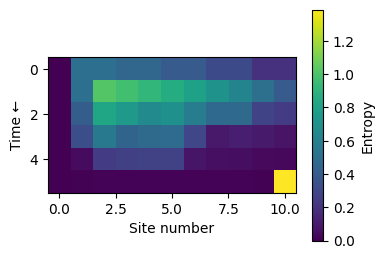

In [12]:
plt.figure(figsize=(4, 3))
plt.imshow(entropies, cmap="viridis")
plt.colorbar(label="Entropy")
plt.xlabel("Site number")
plt.ylabel("Time ←")
plt.show()

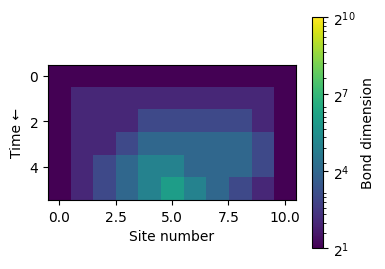

In [13]:
plt.figure(figsize=(4, 3))
plt.imshow(bond_dims, cmap="viridis", norm=LogNorm(vmin=2**1, vmax=2**10))
cbar = plt.colorbar(
    label="Bond dimension",
    format=FuncFormatter(lambda x, pos: f"$2^{{{int(np.log2(x))}}}$"),
    ticks=[2**i for i in range(1, 11, 3)],
)
plt.ylabel("Time ←")
plt.xlabel("Site number")
plt.show()

Let's now take a look at how the truncation error behaves for different bond dimension cutoffs. First, let's look at the bond dimensions appearing in the MPS if we do not impose any truncation.

In [14]:
print(error_mps.bond_dimensions)

[2, 4, 8, 16, 32, 64, 32, 16, 8, 4, 2]


In [15]:
bond_dims = [np.inf, 128, 64, 32, 16, 8, 4, 2]
inv_bond_dims = [1 / bd for bd in bond_dims]
errors = []
for chi in tqdm(bond_dims):
    errors.append(
        np.linalg.norm(
            error_mps.compress(
                chi_max=chi, renormalise=True, return_truncation_errors=True
            )[1]
        )
    )

100%|██████████| 8/8 [00:01<00:00,  5.15it/s]


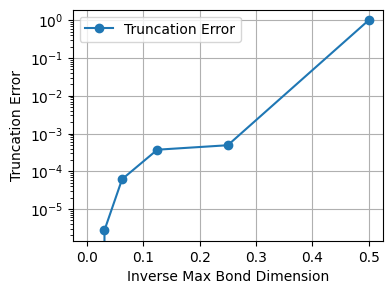

In [16]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, errors, marker="o", label="Truncation Error")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Truncation Error")
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()

Now, we marginalise over the message bits to get the probability distribution over the four possibilities of a logical operator: $I$, $X$, $Z$, $Y$.

In [17]:
sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
logical = marginalise(mps=error_mps, sites_to_marginalise=sites_to_marginalise).dense(
    flatten=True, renormalise=True, norm=1
)
print(logical)

[0.86597587 0.05488773 0.05488773 0.02424866]


For the record, we're hunting for the most likely logical operator to be the identity operator. So that's it, we see the biggest probability assigned to the identity operator. Let's see how the probabilities of the four operators change as we change the bond dimension cutoff.

In [18]:
strategy = "Optimised"
logical_values = [[] for _ in range(4)]

for max_bond_dim in tqdm(bond_dims):
    error_state = "0" * (num_sites - num_logicals)
    logicals_state = "+" * num_logicals
    state_string = logicals_state + error_state
    error_mps = create_custom_product_state(string=state_string)

    error_mps = apply_depolarising_bias(
        mps=error_mps,
        prob_bias_list=0.1,
        sites_to_bias=sites_to_bias,
        renormalise=renormalise,
    )
    for i in [0, 1]:
        error_mps = apply_constraints(
            error_mps,
            logicals_sites[i],
            logicals_tensors,
            renormalise=renormalise,
            result_to_explicit=result_to_explicit,
            strategy=strategy,
            chi_max=max_bond_dim,
            silent=True,
        )
    error_mps = apply_constraints(
        error_mps,
        constraint_sites,
        constraints_tensors,
        renormalise=renormalise,
        result_to_explicit=result_to_explicit,
        strategy=strategy,
        chi_max=max_bond_dim,
        silent=True,
    )

    sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
    logical = marginalise(
        mps=error_mps, sites_to_marginalise=sites_to_marginalise
    ).dense(flatten=True, renormalise=True, norm=1)

    for i in range(4):
        logical_values[i].append(logical[i])

 88%|████████▊ | 7/8 [00:04<00:00,  2.06it/s]/Users/aleksandrberezutskii/mdopt/mdopt/mps/canonical.py:274: RuntimeWarning: invalid value encountered in divide
  dense /= np.linalg.norm(dense, ord=norm)
100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


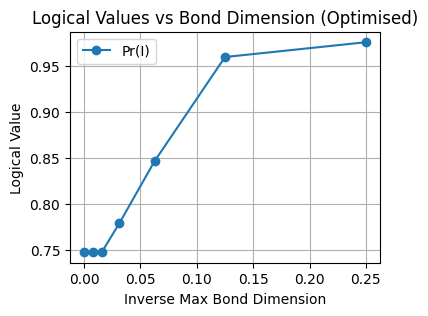

In [19]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, logical_values[0], marker="o", label=f"Pr(I)")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Logical Value")
plt.title("Logical Values vs Bond Dimension (Optimised)")
plt.grid(True)
plt.legend()
plt.show()

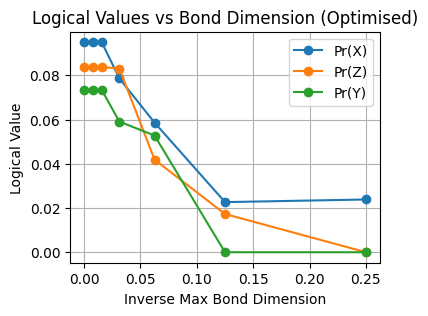

In [20]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, logical_values[1], marker="o", label=f"Pr(X)")
plt.plot(inv_bond_dims, logical_values[2], marker="o", label=f"Pr(Z)")
plt.plot(inv_bond_dims, logical_values[3], marker="o", label=f"Pr(Y)")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Logical Value")
plt.title("Logical Values vs Bond Dimension (Optimised)")
plt.grid(True)
plt.legend()
plt.show()

Let's now put all of this into a function. We'll need this to run the decoder over a bunch of single- and multiqubit errors. For this, we first generate all possible one-qubit errors and first 100 two-qubit errors using `qecsim`.

In [21]:
one_qubit_paulis = pt.ipauli(n_qubits=num_qubits, min_weight=1, max_weight=1)
two_qubit_paulis = pt.ipauli(n_qubits=num_qubits, min_weight=2, max_weight=2)
three_qubit_paulis = pt.ipauli(n_qubits=num_qubits, min_weight=3, max_weight=3)

In [22]:
one_qubit_outputs = [
    decode_custom(
        stabilizers=stabilizer_generators,
        x_logicals=x_logical_operators,
        z_logicals=z_logical_operators,
        error=error,
        chi_max=1e4,
        bias_type="Bitflip",
        bias_prob=0,
        silent=True,
    )
    for error in tqdm(one_qubit_paulis)
]
one_qubit_corrections_distribution = [output[0] for output in one_qubit_outputs]

15it [00:00, 67.94it/s]


In [23]:
two_qubit_outputs = [
    decode_custom(
        stabilizers=stabilizer_generators,
        x_logicals=x_logical_operators,
        z_logicals=z_logical_operators,
        error=error,
        chi_max=1e4,
        bias_type="Bitflip",
        bias_prob=0.1,
        silent=True,
    )
    for error in tqdm(two_qubit_paulis)
]
two_qubit_corrections_distribution = [output[0] for output in two_qubit_outputs]

90it [00:59,  1.51it/s]


In [24]:
three_qubit_outputs = [
    decode_custom(
        stabilizers=stabilizer_generators,
        x_logicals=x_logical_operators,
        z_logicals=z_logical_operators,
        error=error,
        chi_max=1e4,
        bias_type="Bitflip",
        bias_prob=0.1,
        silent=True,
    )
    for error in tqdm(three_qubit_paulis)
]
three_qubit_corrections_distribution = [output[0] for output in three_qubit_outputs]

270it [03:01,  1.49it/s]


In [25]:
def map_distribution_to_pauli(distribution):
    mapping = {0: "I", 1: "X", 2: "Z", 3: "Y"}
    result = []

    for array in distribution:
        max_index = np.argmax(array)
        result.append(mapping[max_index])

    return result

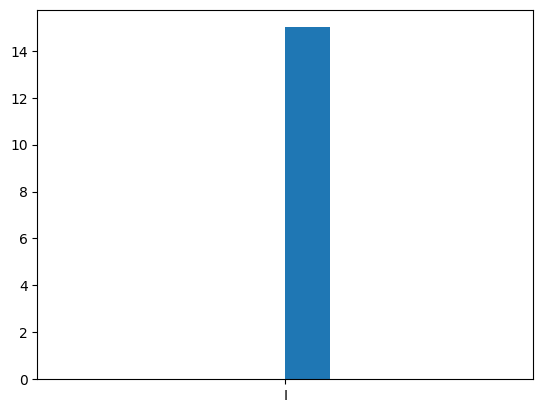

In [26]:
plt.hist(map_distribution_to_pauli(one_qubit_corrections_distribution))
plt.show()

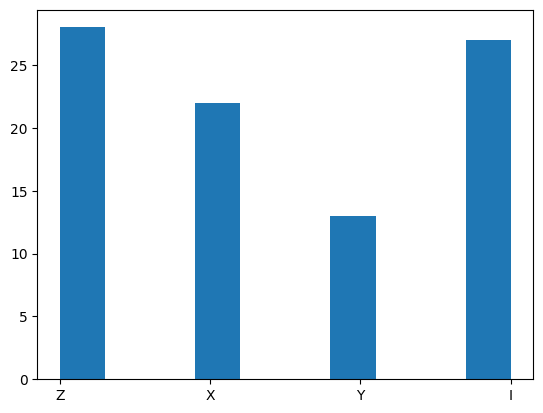

In [27]:
plt.hist(map_distribution_to_pauli(two_qubit_corrections_distribution))
plt.show()

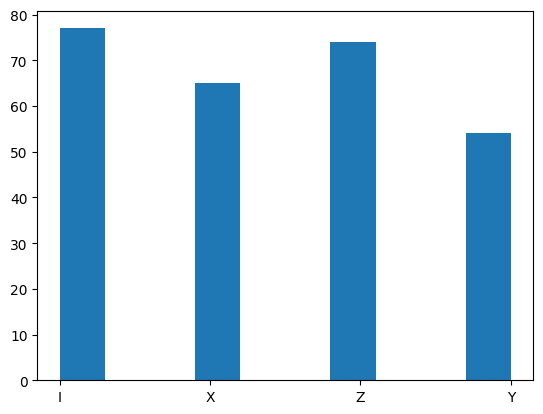

In [28]:
plt.hist(map_distribution_to_pauli(three_qubit_corrections_distribution))
plt.show()

Let's now check by hand that some of the decoder's nontrivial outputs are indeed correct. First of all, from all one-qubit errors we get the Identity operator which corresponds to the fact that the 5-qubit code corrects all one-qubit errors. However, this code can also correct some two-qubit errors.

In [29]:
one_qubit_paulis = list(pt.ipauli(n_qubits=num_qubits, min_weight=1, max_weight=1))
two_qubit_paulis = list(pt.ipauli(n_qubits=num_qubits, min_weight=2, max_weight=2))
three_qubit_paulis = list(pt.ipauli(n_qubits=num_qubits, min_weight=3, max_weight=3))

Let's take a look at the errors which result in the Identity logical operator as the output.

In [30]:
for i, correction in enumerate(
    map_distribution_to_pauli(two_qubit_corrections_distribution)
):
    if correction == "I":
        print(two_qubit_paulis[i])

ZIYII
YIZII
YIYII
XIIXI
YIIYI
XIIIX
YIIIX
YIIIY
IXXII
IXYII
IYXII
IYYII
IXIXI
IXIYI
IZIYI
IYIYI
IXIIY
IYIIZ
IYIIY
IIXYI
IIZZI
IIXIY
IIYIX
IIIXX
IIIZZ
IIIYX
IIIYY


We now  dive a bit more into what is happening inside the decoder to be able to better understand the results. For example, the first error $(Z_0 Y_2)$ from the list above would trigger all the parity checks. This can be seen from the actual tensor network we are building (see the image below). However, in the current setup the stabilisers are being set to $0$, which is the result of the fact that the $\text{XOR}$ tensors we use project out the inputs of odd (i.e., equal to $1$) parity. After applying the logical-operator MPOs and performing marginalization, the process yields a marginal distribution over codewords, each reflecting different parities of the logical operators.

<img src="5-qubit-decoder.png" alt="Tensor-network error-based decoder for the 5-qubit code."/>